
GFLOWNET TRAINING WITH TRAJECTORY BALANCE

Training on 100 trajectories...
Trajectory length: 10
Reward structure:
  High variance (>0.1):   reward = 10.0
  Medium variance (>0.05): reward = 5.0
  Low variance:            reward = 1.0

Read blend: "/home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend"
✓ Loaded template: /home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend
Read blend: "/home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend"
✓ Loaded template: /home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend
Read blend: "/home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend"
✓ Loaded template: /home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend
Read blend: "/home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend"
✓ Loaded template: /home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend
Read blend: "/home/jpleona/jpleona_c/bpygfn/gfn_environ

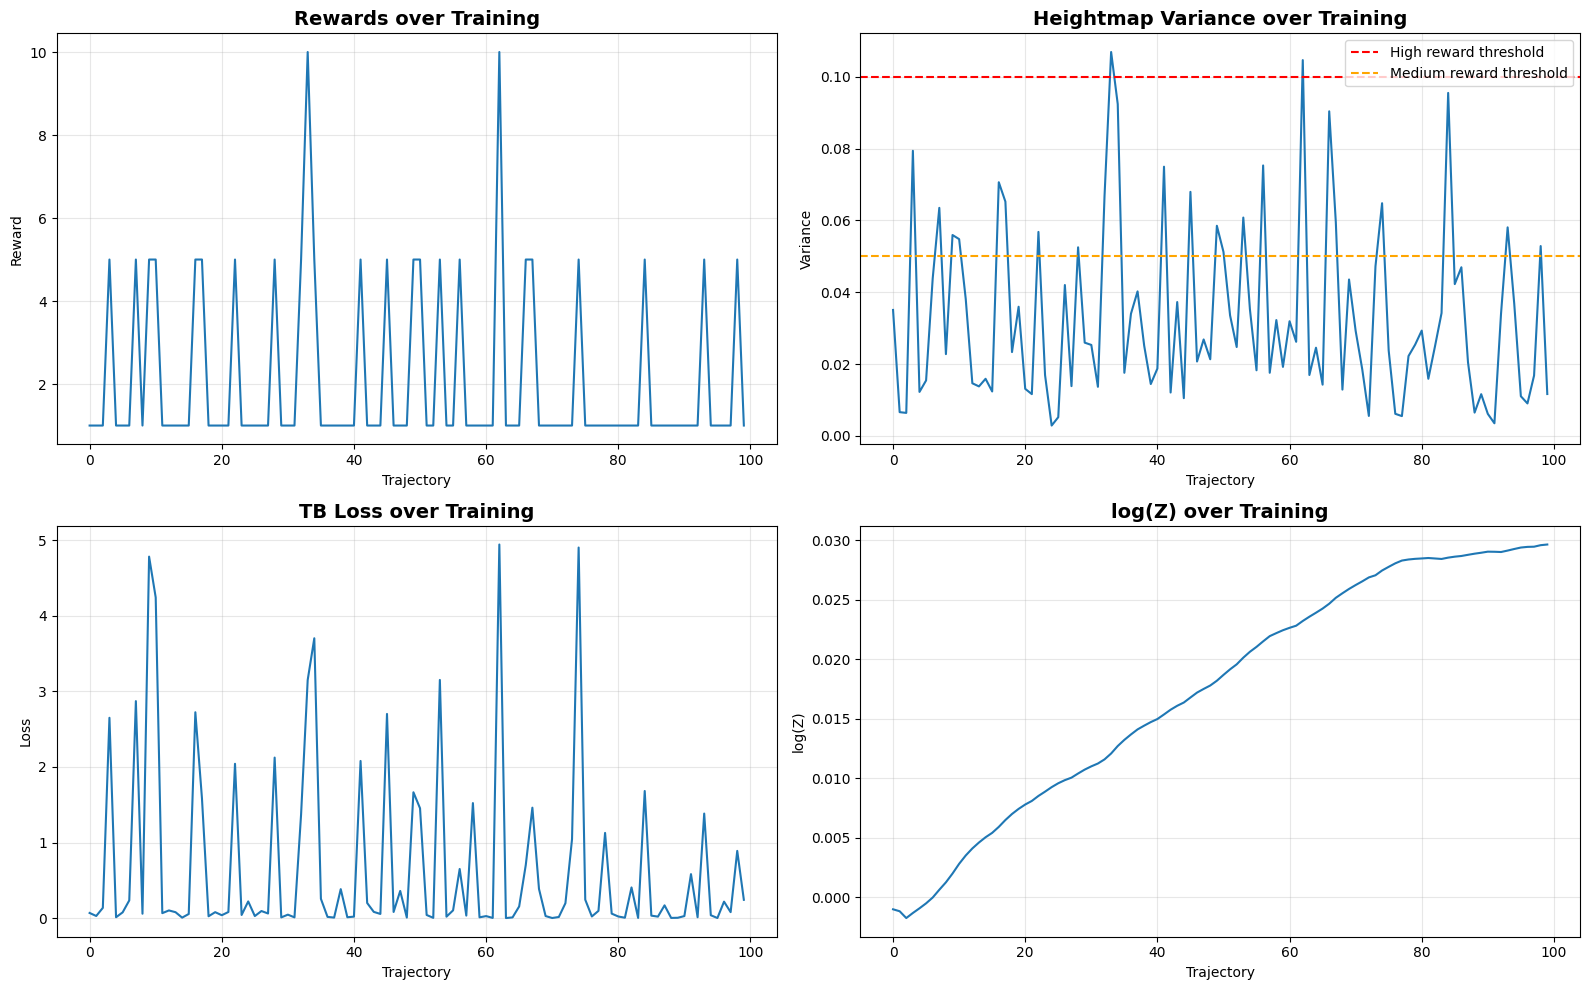


SAMPLING FINAL TRAJECTORY
Read blend: "/home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend"
✓ Loaded template: /home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend
Read blend: "/home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend"
✓ Loaded template: /home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend

Final trajectory:
  Reward: 1.00
  Variance: 0.0369
  Actions taken:
    Step 0: [  6] add_color=4
    Step 1: [ 33] add_color=31
    Step 2: [ 20] add_color=18
    Step 3: [ 12] add_color=10
    Step 4: [ 11] add_color=9
    Step 5: [ 23] add_color=21
    Step 6: [ 21] add_color=19
    Step 7: [  7] add_color=5
    Step 8: [ 34] stop=0
    Step 9: [ 32] add_color=30
Fra:1 Mem:55.37M (Peak 55.37M) | Time:00:13.71 | Rendering 1 / 64 samples
Fra:1 Mem:55.38M (Peak 55.38M) | Time:00:14.22 | Rendering 25 / 64 samples
Fra:1 Mem:55.38M (Peak 55.38M) | Time:00:14.39 | Rendering 50 / 64 samples
Fra:1 Mem:55.38M (Peak 5

NameError: name 'mpimg' is not defined

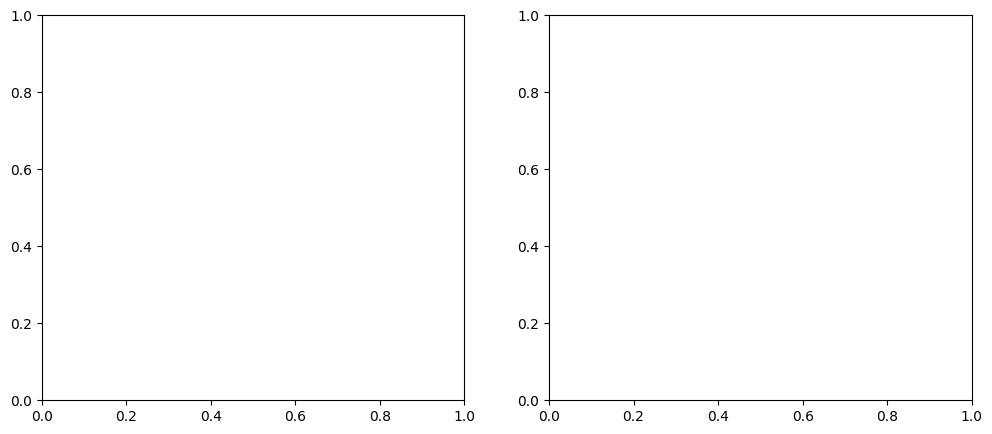

In [3]:
from gfn_environments.single_color_ramp import *
from gfn_environments.single_color_ramp import *
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import os
from gfn_environments.single_color_ramp import *

def screenshot_viewport_to_png(filepath: str, resolution_x: int = 800, resolution_y: int = 600):
    """
    Quick render of the scene from a default viewpoint (no camera setup needed).

    Args:
        filepath: Path where the PNG should be saved (e.g., "./output/screenshot.png")
        resolution_x: Width of the image in pixels
        resolution_y: Height of the image in pixels
    """
    # Ensure directory exists
    os.makedirs(os.path.dirname(filepath), exist_ok=True)

    scene = bpy.context.scene

    # Store original settings
    original_camera = scene.camera
    original_engine = scene.render.engine

    # Create a temporary camera if none exists
    camera_data = bpy.data.cameras.new(name="TempCamera")
    camera_object = bpy.data.objects.new("TempCamera", camera_data)
    bpy.context.collection.objects.link(camera_object)

    # Position camera to view the mesh (adjust these values as needed)
    camera_object.location = (7, -7, 5)
    camera_object.rotation_euler = (1.1, 0, 0.785)

    # Set as active camera
    scene.camera = camera_object

    # Add lighting - Sun light for overall illumination
    sun_data = bpy.data.lights.new(name="TempSun", type='SUN')
    sun_data.energy = 3.0  # Brightness
    sun_object = bpy.data.objects.new("TempSun", sun_data)
    bpy.context.collection.objects.link(sun_object)
    sun_object.location = (5, 5, 10)
    sun_object.rotation_euler = (0.7, 0.3, 0)

    # Add fill light for better visibility
    fill_data = bpy.data.lights.new(name="TempFill", type='AREA')
    fill_data.energy = 100.0
    fill_data.size = 5.0
    fill_object = bpy.data.objects.new("TempFill", fill_data)
    bpy.context.collection.objects.link(fill_object)
    fill_object.location = (-5, -5, 8)
    fill_object.rotation_euler = (1.2, 0, -0.785)

    # Configure render settings for quick preview
    scene.render.engine = 'BLENDER_EEVEE_NEXT'  # Fast rendering (Blender 4.x)
    scene.render.image_settings.file_format = 'PNG'
    scene.render.filepath = filepath
    scene.render.resolution_x = resolution_x
    scene.render.resolution_y = resolution_y
    scene.render.resolution_percentage = 100

    # Quick render
    bpy.ops.render.render(write_still=True)

    # Cleanup: remove temporary objects
    bpy.data.objects.remove(camera_object, do_unlink=True)
    bpy.data.cameras.remove(camera_data)
    bpy.data.objects.remove(sun_object, do_unlink=True)
    bpy.data.lights.remove(sun_data)
    bpy.data.objects.remove(fill_object, do_unlink=True)
    bpy.data.lights.remove(fill_data)

    # Restore original settings
    scene.camera = original_camera
    scene.render.engine = original_engine

    print(f"Viewport screenshot saved to: {filepath}")



def simple_gfn_training():
    """
    Simple GFlowNet training with Trajectory Balance loss.
    Rewards high and medium variance heightmaps.
    Trajectories are length 10.
    """
    import torch.nn as nn
    import torch.optim as optim
    from torch.distributions import Categorical

    print("\n" + "=" * 80)
    print("GFLOWNET TRAINING WITH TRAJECTORY BALANCE")
    print("=" * 80)

    env = v2StepWEnv()
    action_dim = env.n_actions
    trajectory_length = 10

    # GFlowNet model with forward and backward policies
    class GFlowNetModel(nn.Module):
        def __init__(self, state_dim, action_dim, hidden_dim=128):
            super().__init__()

            # Forward policy P_F
            self.forward_net = nn.Sequential(
                nn.Linear(state_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, action_dim)
            )

            # Backward policy P_B
            self.backward_net = nn.Sequential(
                nn.Linear(state_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, action_dim)
            )

            # Log partition function Z
            self.log_Z = nn.Parameter(torch.tensor(0.0))

        def forward_policy(self, state_history):
            """Get forward action probabilities"""
            batch_size = state_history.shape[0]
            state_flat = state_history.reshape(batch_size, -1)
            logits = self.forward_net(state_flat)
            return torch.softmax(logits, dim=-1)

        def backward_policy(self, state_history):
            """Get backward action probabilities"""
            batch_size = state_history.shape[0]
            state_flat = state_history.reshape(batch_size, -1)
            logits = self.backward_net(state_flat)
            return torch.softmax(logits, dim=-1)

    # Initialize
    state_dim = trajectory_length * action_dim
    model = GFlowNetModel(state_dim, action_dim)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # Reward function: variance of heightmap
    def compute_reward(blender_api):
        heightmap = blender_api.get_heightmap()
        variance = heightmap.var().item()

        # Reward high and medium variance
        if variance > 0.1:
            reward = 10.0
        elif variance > 0.05:
            reward = 5.0
        else:
            reward = 1.0

        return reward, variance

    # Sample trajectory with forward policy
    def sample_trajectory(model, env, blender_api, use_policy=True):
        state = torch.zeros(trajectory_length, action_dim)
        actions_taken = []
        states_visited = [state.clone()]  # Track states for backward policy
        color_slot_idx = 0

        for step in range(trajectory_length):
            # Get current state (history so far)
            state_input = state.unsqueeze(0)  # [1, max_steps, action_dim]

            if use_policy:
                # Get action probabilities from forward policy
                with torch.no_grad():
                    probs = model.forward_policy(state_input).squeeze(0)
            else:
                # Random policy for exploration
                probs = torch.ones(action_dim) / action_dim

            # Sample action
            dist = Categorical(probs)
            action_idx = dist.sample()

            # Convert to action
            action_def = env.tensor_to_action[action_idx.item()]
            action_one_hot = action_def.to_one_hot(action_dim)

            # Execute on Blender
            if action_def.action_key == 'add_color':
                if color_slot_idx < env.max_colors:
                    env.execute_one_hot_action(blender_api, action_one_hot, slot_idx=color_slot_idx)
                    color_slot_idx += 1
            elif action_def.action_key != 'stop':
                env.execute_one_hot_action(blender_api, action_one_hot)

            # Record
            state[step] = action_one_hot
            actions_taken.append(action_idx.item())
            states_visited.append(state.clone())

        # Compute reward
        reward, variance = compute_reward(blender_api)

        return state, actions_taken, states_visited, reward, variance

    # Trajectory Balance Loss
    def compute_tb_loss(model, state_history, actions_taken, states_visited, reward):
        """
        Compute trajectory balance loss:
        L_TB(τ) = [log(Z_θ * ∏P_F) - log(R(x) * ∏P_B)]²
        """
        # Forward flow: Z * product of forward probabilities
        log_forward_flow = model.log_Z

        for step, action_idx in enumerate(actions_taken):
            state_input = states_visited[step].unsqueeze(0)
            forward_probs = model.forward_policy(state_input)
            log_forward_flow = log_forward_flow + torch.log(forward_probs[0, action_idx] + 1e-8)

        # Backward flow: R(x) * product of backward probabilities
        log_backward_flow = torch.log(torch.tensor(reward) + 1e-8)

        for step in range(len(actions_taken) - 1, -1, -1):
            state_input = states_visited[step + 1].unsqueeze(0)
            backward_probs = model.backward_policy(state_input)
            log_backward_flow = log_backward_flow + torch.log(backward_probs[0, actions_taken[step]] + 1e-8)

        # TB loss: squared difference
        loss = (log_forward_flow - log_backward_flow) ** 2

        return loss

    # Training loop
    num_trajectories = 100
    print(f"\nTraining on {num_trajectories} trajectories...")
    print(f"Trajectory length: {trajectory_length}")
    print(f"Reward structure:")
    print(f"  High variance (>0.1):   reward = 10.0")
    print(f"  Medium variance (>0.05): reward = 5.0")
    print(f"  Low variance:            reward = 1.0")
    print()

    rewards_history = []
    variances_history = []
    losses_history = []
    log_Z_history = []

    for traj_idx in range(num_trajectories):
        # Reset Blender
        load_blend_single_color_ramp()
        blender_api = BlenderTerrainAPI()

        # Sample trajectory (use random policy for first 20, then learned policy)
        use_policy = traj_idx >= 20
        state, actions_taken, states_visited, reward, variance = sample_trajectory(
            model, env, blender_api, use_policy=use_policy
        )

        # Compute TB loss
        loss = compute_tb_loss(model, state, actions_taken, states_visited, reward)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Record
        rewards_history.append(reward)
        variances_history.append(variance)
        losses_history.append(loss.item())
        log_Z_history.append(model.log_Z.item())

        if (traj_idx + 1) % 10 == 0:
            avg_reward = np.mean(rewards_history[-10:])
            avg_variance = np.mean(variances_history[-10:])
            print(f"Trajectory {traj_idx+1}/{num_trajectories}: "
                  f"Reward={reward:.2f}, Variance={variance:.4f}, "
                  f"Loss={loss.item():.4f}, log_Z={model.log_Z.item():.4f}, "
                  f"Avg(last 10): Reward={avg_reward:.2f}, Variance={avg_variance:.4f}")

    # Plot training progress
    print("\n" + "=" * 80)
    print("TRAINING RESULTS")
    print("=" * 80)

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    # Rewards
    axes[0, 0].plot(rewards_history)
    axes[0, 0].set_title('Rewards over Training', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Trajectory')
    axes[0, 0].set_ylabel('Reward')
    axes[0, 0].grid(True, alpha=0.3)

    # Variances
    axes[0, 1].plot(variances_history)
    axes[0, 1].set_title('Heightmap Variance over Training', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Trajectory')
    axes[0, 1].set_ylabel('Variance')
    axes[0, 1].axhline(y=0.1, color='r', linestyle='--', label='High reward threshold')
    axes[0, 1].axhline(y=0.05, color='orange', linestyle='--', label='Medium reward threshold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Losses
    axes[1, 0].plot(losses_history)
    axes[1, 0].set_title('TB Loss over Training', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Trajectory')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].grid(True, alpha=0.3)

    # Log Z
    axes[1, 1].plot(log_Z_history)
    axes[1, 1].set_title('log(Z) over Training', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Trajectory')
    axes[1, 1].set_ylabel('log(Z)')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Sample final trajectory to visualize
    print("\n" + "=" * 80)
    print("SAMPLING FINAL TRAJECTORY")
    print("=" * 80)

    load_blend_single_color_ramp()
    blender_api = BlenderTerrainAPI()

    final_state, final_actions, _, final_reward, final_variance = sample_trajectory(
        model, env, blender_api, use_policy=True
    )

    print(f"\nFinal trajectory:")
    print(f"  Reward: {final_reward:.2f}")
    print(f"  Variance: {final_variance:.4f}")
    print(f"  Actions taken:")
    for i, action_idx in enumerate(final_actions):
        action_def = env.tensor_to_action[action_idx]
        print(f"    Step {i}: [{action_idx:3d}] {action_def.action_key}={action_def.value}")

    # Save final render
    screenshot_viewport_to_png(filepath="./tests/file_dump/gfn_final_sample.png")
    heightmap = blender_api.get_heightmap()

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Render
    img = mpimg.imread("./tests/file_dump/gfn_final_sample.png")
    axes[0].imshow(img)
    axes[0].set_title(f'Final Render (Reward={final_reward:.2f})', fontsize=14, fontweight='bold')
    axes[0].axis('off')

    # Heightmap
    heightmap_np = heightmap.detach().cpu().numpy()
    im = axes[1].imshow(heightmap_np, cmap='terrain', interpolation='nearest')
    axes[1].set_title(f'Heightmap (Variance={final_variance:.4f})', fontsize=14, fontweight='bold')
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1])

    plt.tight_layout()
    plt.show()

    print("\n" + "=" * 80)
    print("✅ Training complete!")
    print(f"Final log(Z) = {model.log_Z.item():.4f}")
    print("=" * 80)

    return model, rewards_history, variances_history


if __name__ == "__main__":
    model, rewards, variances = simple_gfn_training()


GFLOWNET TRAINING WITH TRAJECTORY BALANCE + REPLAY BUFFER

Training Configuration:
  Epochs: 50
  Trajectories per epoch: 5
  Validation every 5 epochs
  Trajectory length: 10
  Replay buffer max size: 1000

Reward structure:
  High variance (>0.1):   reward = 10.0
  Medium variance (>0.05): reward = 5.0
  Low variance:            reward = 1.0


Epoch 1/50
----------------------------------------
Read blend: "/home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend"
✓ Loaded template: /home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend
Read blend: "/home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend"
✓ Loaded template: /home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend
  Sampled trajectory 1/5: Reward=1.00, Variance=0.0074, Buffer size=1
Read blend: "/home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend"
✓ Loaded template: /home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blen

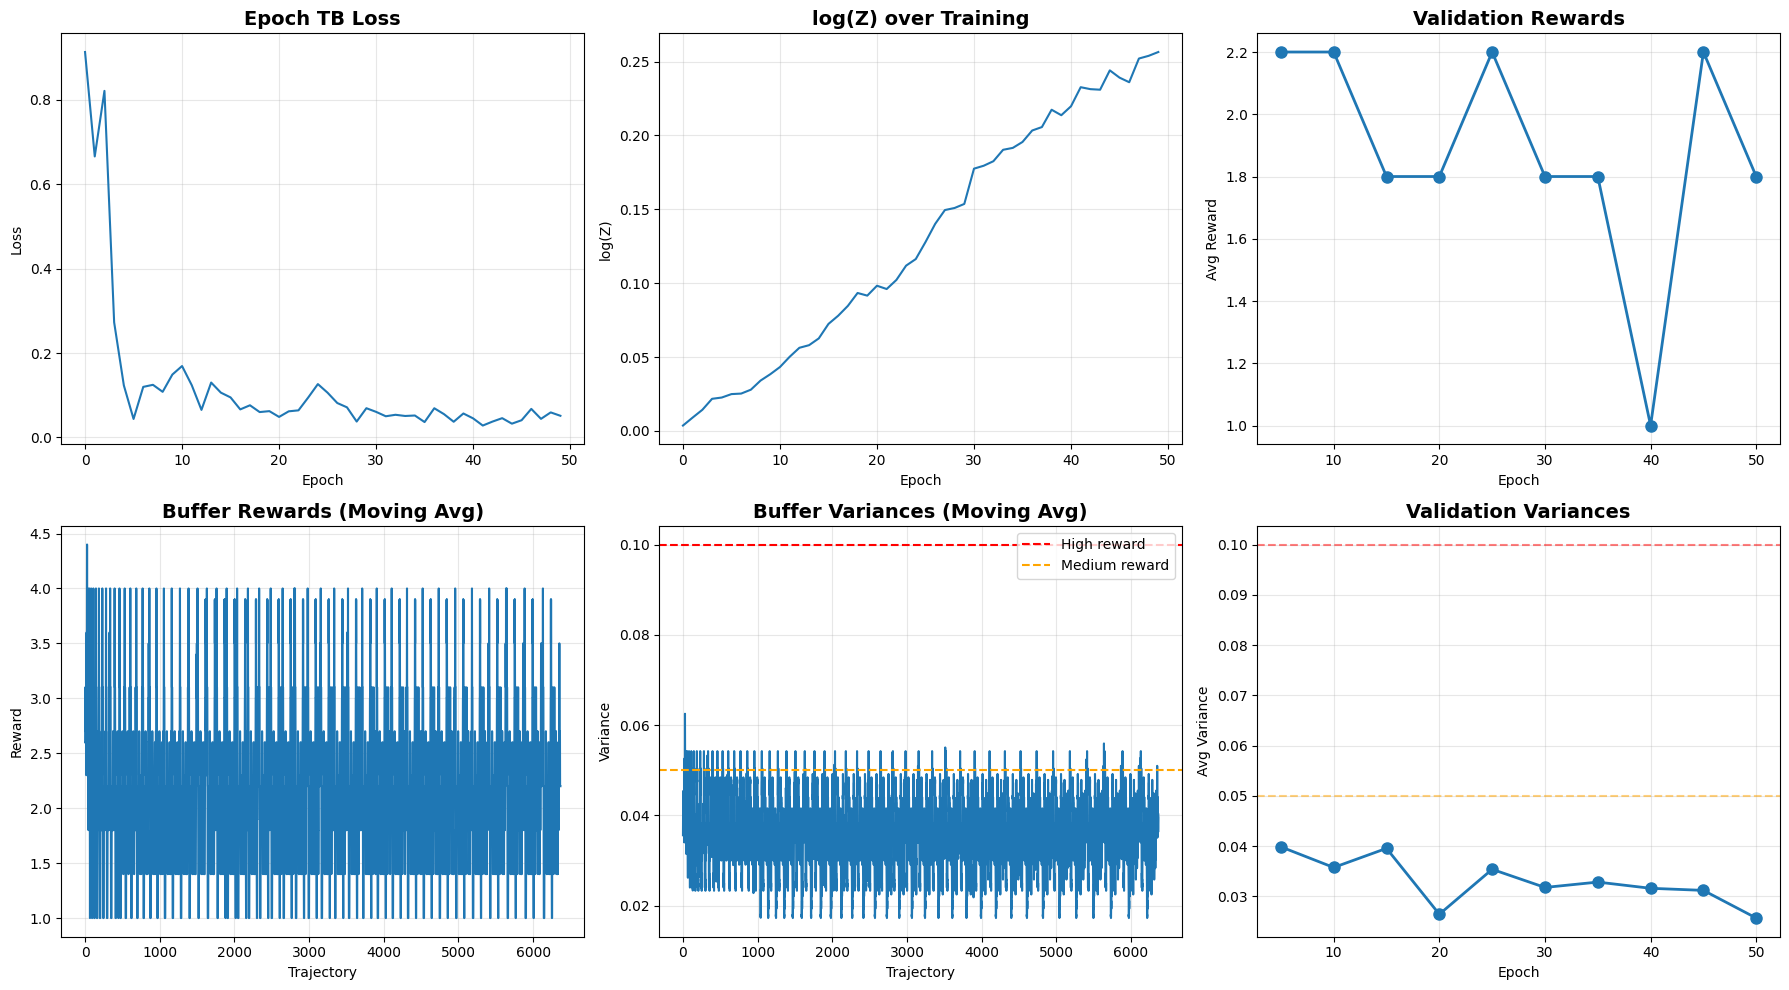


SAMPLING FINAL TRAJECTORIES
Read blend: "/home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend"
✓ Loaded template: /home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend
Read blend: "/home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend"
✓ Loaded template: /home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend

Sample 1:
  Reward: 10.00
  Variance: 0.1387
Fra:1 Mem:55.38M (Peak 55.43M) | Time:00:00.00 | Rendering 1 / 64 samples
Fra:1 Mem:55.38M (Peak 55.43M) | Time:00:00.04 | Rendering 25 / 64 samples
Fra:1 Mem:55.38M (Peak 55.43M) | Time:00:00.09 | Rendering 50 / 64 samples
Fra:1 Mem:55.38M (Peak 55.43M) | Time:00:00.11 | Rendering 64 / 64 samples
Saved: 'tests/file_dump/gfn_final_sample_0.png'
Time: 00:00.13 (Saving: 00:00.01)

Viewport screenshot saved to: ./tests/file_dump/gfn_final_sample_0.png
Read blend: "/home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend"
✓ Loaded template: /home/jpleona

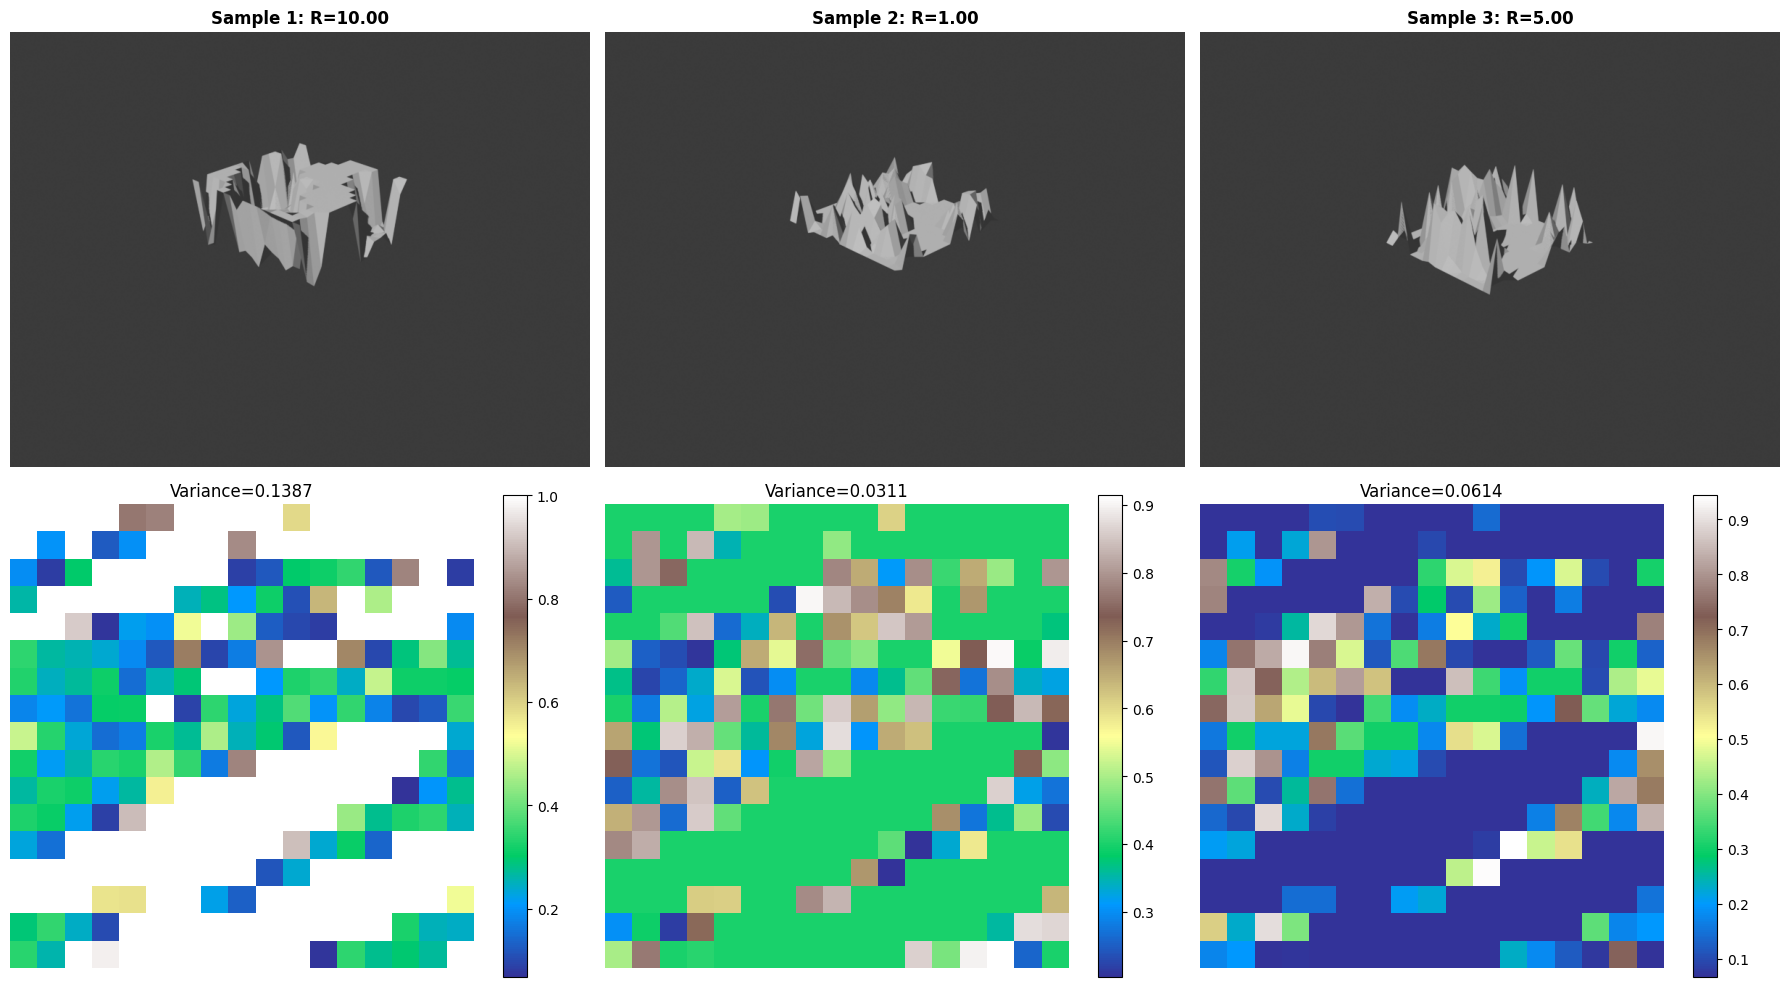


✅ Training complete!
Final log(Z) = 0.2565
Final buffer size: 250


In [6]:
def simple_gfn_training():
    """
    GFlowNet training with Trajectory Balance loss, replay buffer, and validation.
    Rewards high and medium variance heightmaps.
    Trajectories are length 10.
    """

    import matplotlib.image as mpimg
    import torch.nn as nn
    import torch.optim as optim
    from torch.distributions import Categorical
    from collections import deque

    print("\n" + "=" * 80)
    print("GFLOWNET TRAINING WITH TRAJECTORY BALANCE + REPLAY BUFFER")
    print("=" * 80)

    env = v2StepWEnv()
    action_dim = env.n_actions
    trajectory_length = 10

    # GFlowNet model with forward and backward policies
    class GFlowNetModel(nn.Module):
        def __init__(self, state_dim, action_dim, hidden_dim=128):
            super().__init__()

            # Forward policy P_F
            self.forward_net = nn.Sequential(
                nn.Linear(state_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, action_dim)
            )

            # Backward policy P_B
            self.backward_net = nn.Sequential(
                nn.Linear(state_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, action_dim)
            )

            # Log partition function Z
            self.log_Z = nn.Parameter(torch.tensor(0.0))

        def forward_policy(self, state_history):
            """Get forward action probabilities"""
            batch_size = state_history.shape[0]
            state_flat = state_history.reshape(batch_size, -1)
            logits = self.forward_net(state_flat)
            return torch.softmax(logits, dim=-1)

        def backward_policy(self, state_history):
            """Get backward action probabilities"""
            batch_size = state_history.shape[0]
            state_flat = state_history.reshape(batch_size, -1)
            logits = self.backward_net(state_flat)
            return torch.softmax(logits, dim=-1)

    # Initialize
    state_dim = trajectory_length * action_dim
    model = GFlowNetModel(state_dim, action_dim)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # Replay buffer
    replay_buffer = []
    max_buffer_size = 1000

    # Reward function: variance of heightmap
    def compute_reward(blender_api):
        heightmap = blender_api.get_heightmap()
        variance = heightmap.var().item()

        # Reward high and medium variance
        if variance > 0.1:
            reward = 10.0
        elif variance > 0.05:
            reward = 5.0
        else:
            reward = 1.0

        return reward, variance

    # Sample trajectory with forward policy
    def sample_trajectory(model, env, blender_api, use_policy=True):
        state = torch.zeros(trajectory_length, action_dim)
        actions_taken = []
        states_visited = [state.clone()]  # Track states for backward policy
        color_slot_idx = 0

        for step in range(trajectory_length):
            # Get current state (history so far)
            state_input = state.unsqueeze(0)  # [1, max_steps, action_dim]

            if use_policy:
                # Get action probabilities from forward policy
                with torch.no_grad():
                    probs = model.forward_policy(state_input).squeeze(0)
            else:
                # Random policy for exploration
                probs = torch.ones(action_dim) / action_dim

            # Sample action
            dist = Categorical(probs)
            action_idx = dist.sample()

            # Convert to action
            action_def = env.tensor_to_action[action_idx.item()]
            action_one_hot = action_def.to_one_hot(action_dim)

            # Execute on Blender
            if action_def.action_key == 'add_color':
                if color_slot_idx < env.max_colors:
                    env.execute_one_hot_action(blender_api, action_one_hot, slot_idx=color_slot_idx)
                    color_slot_idx += 1
            elif action_def.action_key != 'stop':
                env.execute_one_hot_action(blender_api, action_one_hot)

            # Record
            state[step] = action_one_hot
            actions_taken.append(action_idx.item())
            states_visited.append(state.clone())

        # Compute reward
        reward, variance = compute_reward(blender_api)

        return state, actions_taken, states_visited, reward, variance

    # Trajectory Balance Loss
    def compute_tb_loss(model, state_history, actions_taken, states_visited, reward):
        """
        Compute trajectory balance loss:
        L_TB(τ) = [log(Z_θ * ∏P_F) - log(R(x) * ∏P_B)]²
        """
        # Forward flow: Z * product of forward probabilities
        log_forward_flow = model.log_Z

        for step, action_idx in enumerate(actions_taken):
            state_input = states_visited[step].unsqueeze(0)
            forward_probs = model.forward_policy(state_input)
            log_forward_flow = log_forward_flow + torch.log(forward_probs[0, action_idx] + 1e-8)

        # Backward flow: R(x) * product of backward probabilities
        log_backward_flow = torch.log(torch.tensor(reward) + 1e-8)

        for step in range(len(actions_taken) - 1, -1, -1):
            state_input = states_visited[step + 1].unsqueeze(0)
            backward_probs = model.backward_policy(state_input)
            log_backward_flow = log_backward_flow + torch.log(backward_probs[0, actions_taken[step]] + 1e-8)

        # TB loss: squared difference
        loss = (log_forward_flow - log_backward_flow) ** 2

        return loss

    # Validation function
    def validate(model, env, num_val_trajectories=10):
        """Sample validation trajectories and compute average reward/variance"""
        val_rewards = []
        val_variances = []

        print("\n  Validating...")
        for _ in range(num_val_trajectories):
            load_blend_single_color_ramp()
            blender_api = BlenderTerrainAPI()

            _, _, _, reward, variance = sample_trajectory(model, env, blender_api, use_policy=True)
            val_rewards.append(reward)
            val_variances.append(variance)

        avg_reward = np.mean(val_rewards)
        avg_variance = np.mean(val_variances)

        print(f"  Validation: Avg Reward={avg_reward:.2f}, Avg Variance={avg_variance:.4f}")
        return avg_reward, avg_variance

    # Training hyperparameters
    num_epochs = 50
    trajectories_per_epoch = 5
    validation_interval = 5

    print(f"\nTraining Configuration:")
    print(f"  Epochs: {num_epochs}")
    print(f"  Trajectories per epoch: {trajectories_per_epoch}")
    print(f"  Validation every {validation_interval} epochs")
    print(f"  Trajectory length: {trajectory_length}")
    print(f"  Replay buffer max size: {max_buffer_size}")
    print(f"\nReward structure:")
    print(f"  High variance (>0.1):   reward = 10.0")
    print(f"  Medium variance (>0.05): reward = 5.0")
    print(f"  Low variance:            reward = 1.0")
    print()

    rewards_history = []
    variances_history = []
    losses_history = []
    log_Z_history = []
    val_rewards_history = []
    val_variances_history = []
    val_epochs = []

    total_trajectories = 0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 40)

        # Sample new trajectories and add to replay buffer
        for traj_idx in range(trajectories_per_epoch):
            # Reset Blender
            load_blend_single_color_ramp()
            blender_api = BlenderTerrainAPI()

            # Sample trajectory (use random policy for first 2 epochs, then learned policy)
            use_policy = epoch >= 2
            state, actions_taken, states_visited, reward, variance = sample_trajectory(
                model, env, blender_api, use_policy=use_policy
            )

            # Add to replay buffer
            replay_buffer.append({
                'state': state,
                'actions': actions_taken,
                'states_visited': states_visited,
                'reward': reward,
                'variance': variance
            })

            # Trim buffer if too large
            if len(replay_buffer) > max_buffer_size:
                replay_buffer.pop(0)

            total_trajectories += 1

            print(f"  Sampled trajectory {traj_idx+1}/{trajectories_per_epoch}: "
                  f"Reward={reward:.2f}, Variance={variance:.4f}, "
                  f"Buffer size={len(replay_buffer)}")

        # Train on entire replay buffer
        print(f"\n  Training on {len(replay_buffer)} trajectories from replay buffer...")
        epoch_losses = []

        for buffer_entry in replay_buffer:
            # Compute TB loss
            loss = compute_tb_loss(
                model,
                buffer_entry['state'],
                buffer_entry['actions'],
                buffer_entry['states_visited'],
                buffer_entry['reward']
            )

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

        avg_epoch_loss = np.mean(epoch_losses)

        # Record statistics from buffer
        buffer_rewards = [entry['reward'] for entry in replay_buffer]
        buffer_variances = [entry['variance'] for entry in replay_buffer]

        rewards_history.extend(buffer_rewards)
        variances_history.extend(buffer_variances)
        losses_history.append(avg_epoch_loss)
        log_Z_history.append(model.log_Z.item())

        print(f"  Epoch loss: {avg_epoch_loss:.4f}, log_Z={model.log_Z.item():.4f}")
        print(f"  Buffer stats: Avg Reward={np.mean(buffer_rewards):.2f}, "
              f"Avg Variance={np.mean(buffer_variances):.4f}")

        # Validation
        if (epoch + 1) % validation_interval == 0:
            val_reward, val_variance = validate(model, env, num_val_trajectories=10)
            val_rewards_history.append(val_reward)
            val_variances_history.append(val_variance)
            val_epochs.append(epoch + 1)

    # Plot training progress
    print("\n" + "=" * 80)
    print("TRAINING RESULTS")
    print("=" * 80)

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    # Epoch losses
    axes[0, 0].plot(losses_history)
    axes[0, 0].set_title('Epoch TB Loss', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].grid(True, alpha=0.3)

    # Log Z
    axes[0, 1].plot(log_Z_history)
    axes[0, 1].set_title('log(Z) over Training', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('log(Z)')
    axes[0, 1].grid(True, alpha=0.3)

    # Validation rewards
    axes[0, 2].plot(val_epochs, val_rewards_history, 'o-', linewidth=2, markersize=8)
    axes[0, 2].set_title('Validation Rewards', fontsize=14, fontweight='bold')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('Avg Reward')
    axes[0, 2].grid(True, alpha=0.3)

    # Buffer rewards (moving average)
    window = 10
    if len(rewards_history) > window:
        rewards_ma = np.convolve(rewards_history, np.ones(window)/window, mode='valid')
        axes[1, 0].plot(rewards_ma)
    axes[1, 0].set_title('Buffer Rewards (Moving Avg)', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Trajectory')
    axes[1, 0].set_ylabel('Reward')
    axes[1, 0].grid(True, alpha=0.3)

    # Buffer variances (moving average)
    if len(variances_history) > window:
        variances_ma = np.convolve(variances_history, np.ones(window)/window, mode='valid')
        axes[1, 1].plot(variances_ma)
    axes[1, 1].axhline(y=0.1, color='r', linestyle='--', label='High reward')
    axes[1, 1].axhline(y=0.05, color='orange', linestyle='--', label='Medium reward')
    axes[1, 1].set_title('Buffer Variances (Moving Avg)', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Trajectory')
    axes[1, 1].set_ylabel('Variance')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    # Validation variances
    axes[1, 2].plot(val_epochs, val_variances_history, 'o-', linewidth=2, markersize=8)
    axes[1, 2].axhline(y=0.1, color='r', linestyle='--', alpha=0.5)
    axes[1, 2].axhline(y=0.05, color='orange', linestyle='--', alpha=0.5)
    axes[1, 2].set_title('Validation Variances', fontsize=14, fontweight='bold')
    axes[1, 2].set_xlabel('Epoch')
    axes[1, 2].set_ylabel('Avg Variance')
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Sample final trajectories to visualize
    print("\n" + "=" * 80)
    print("SAMPLING FINAL TRAJECTORIES")
    print("=" * 80)

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    for i in range(3):
        load_blend_single_color_ramp()
        blender_api = BlenderTerrainAPI()

        final_state, final_actions, _, final_reward, final_variance = sample_trajectory(
            model, env, blender_api, use_policy=True
        )

        print(f"\nSample {i+1}:")
        print(f"  Reward: {final_reward:.2f}")
        print(f"  Variance: {final_variance:.4f}")

        # Save render
        screenshot_path = f"./tests/file_dump/gfn_final_sample_{i}.png"
        screenshot_viewport_to_png(filepath=screenshot_path)
        heightmap = blender_api.get_heightmap()

        # Render
        img = mpimg.imread(screenshot_path)
        axes[0, i].imshow(img)
        axes[0, i].set_title(f'Sample {i+1}: R={final_reward:.2f}', fontsize=12, fontweight='bold')
        axes[0, i].axis('off')

        # Heightmap
        heightmap_np = heightmap.detach().cpu().numpy()
        im = axes[1, i].imshow(heightmap_np, cmap='terrain', interpolation='nearest')
        axes[1, i].set_title(f'Variance={final_variance:.4f}', fontsize=12)
        axes[1, i].axis('off')
        plt.colorbar(im, ax=axes[1, i])

    plt.tight_layout()
    plt.show()

    print("\n" + "=" * 80)
    print("✅ Training complete!")
    print(f"Final log(Z) = {model.log_Z.item():.4f}")
    print(f"Final buffer size: {len(replay_buffer)}")
    print("=" * 80)

    return model, rewards_history, variances_history


if __name__ == "__main__":
    model, rewards, variances = simple_gfn_training()


GFLOWNET VS RANDOM POLICY COMPARISON

PHASE 1: TRAINING GFLOWNET

Reward structure (based on heightmap range = max - min):
  High range (>2.0):   reward = 10.0
  Medium range (>1.0): reward = 5.0
  Low range:           reward = 1.0

Training for 30 epochs with 5 trajectories per epoch...
Read blend: "/home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend"
✓ Loaded template: /home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend
Read blend: "/home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend"
✓ Loaded template: /home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend
Read blend: "/home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend"
✓ Loaded template: /home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend
Read blend: "/home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend"
✓ Loaded template: /home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend
Re

/tmp/ipykernel_3496134/2657251861.py:302: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax3.boxplot([gfn_rewards, random_rewards], labels=['GFlowNet', 'Random'])


Fra:1 Mem:55.38M (Peak 55.43M) | Time:00:00.07 | Rendering 25 / 64 samples
Fra:1 Mem:55.38M (Peak 55.43M) | Time:00:00.12 | Rendering 50 / 64 samples
Fra:1 Mem:55.38M (Peak 55.43M) | Time:00:00.14 | Rendering 64 / 64 samples
Saved: 'tests/file_dump/comparison_gfn_0.png'
Time: 00:00.16 (Saving: 00:00.01)

Viewport screenshot saved to: ./tests/file_dump/comparison_gfn_0.png


NameError: name 'mpimg' is not defined

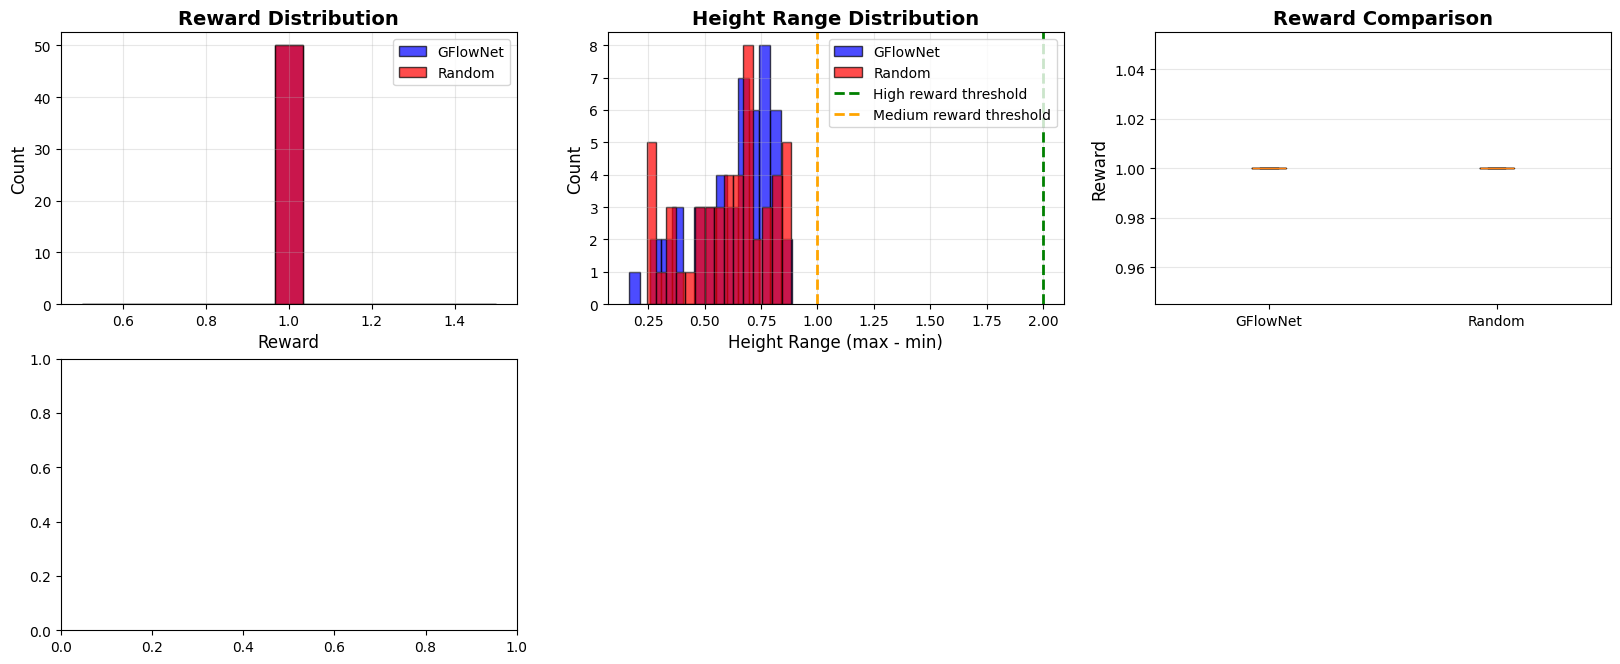